Using device: cuda
Target Sampling Rate (Hz): 1000.0
Window Size (samples): 1000
Classes: ['man', 'car', 'other']
Base Data Directory: DATA
Using Aggressive Augmentation for 'other' class.

Looking for new 'other' files in DATA\OTHER...
  Found 7 potential new 'other' files.

--- Processing 'man' Data Files ---
  Processing file: man.csv (Label: man)...
    Created 2479 windows for this file.

--- Processing 'man2' Data Files (354 files) ---
  Processing file: P1_Barefoot_01.csv (Label: man)...
    Created 76 windows for this file.
  Processing file: P1_Barefoot_02.csv (Label: man)...
    Created 76 windows for this file.
  Processing file: P1_Barefoot_03.csv (Label: man)...
    Created 76 windows for this file.
  Processing file: P1_Barefoot_04.csv (Label: man)...
    Created 76 windows for this file.
  Processing file: P1_Barefoot_05.csv (Label: man)...
    Created 76 windows for this file.
  Processing file: P1_Shoe1_01.csv (Label: man)...
    Created 76 windows for this file.
  Pro

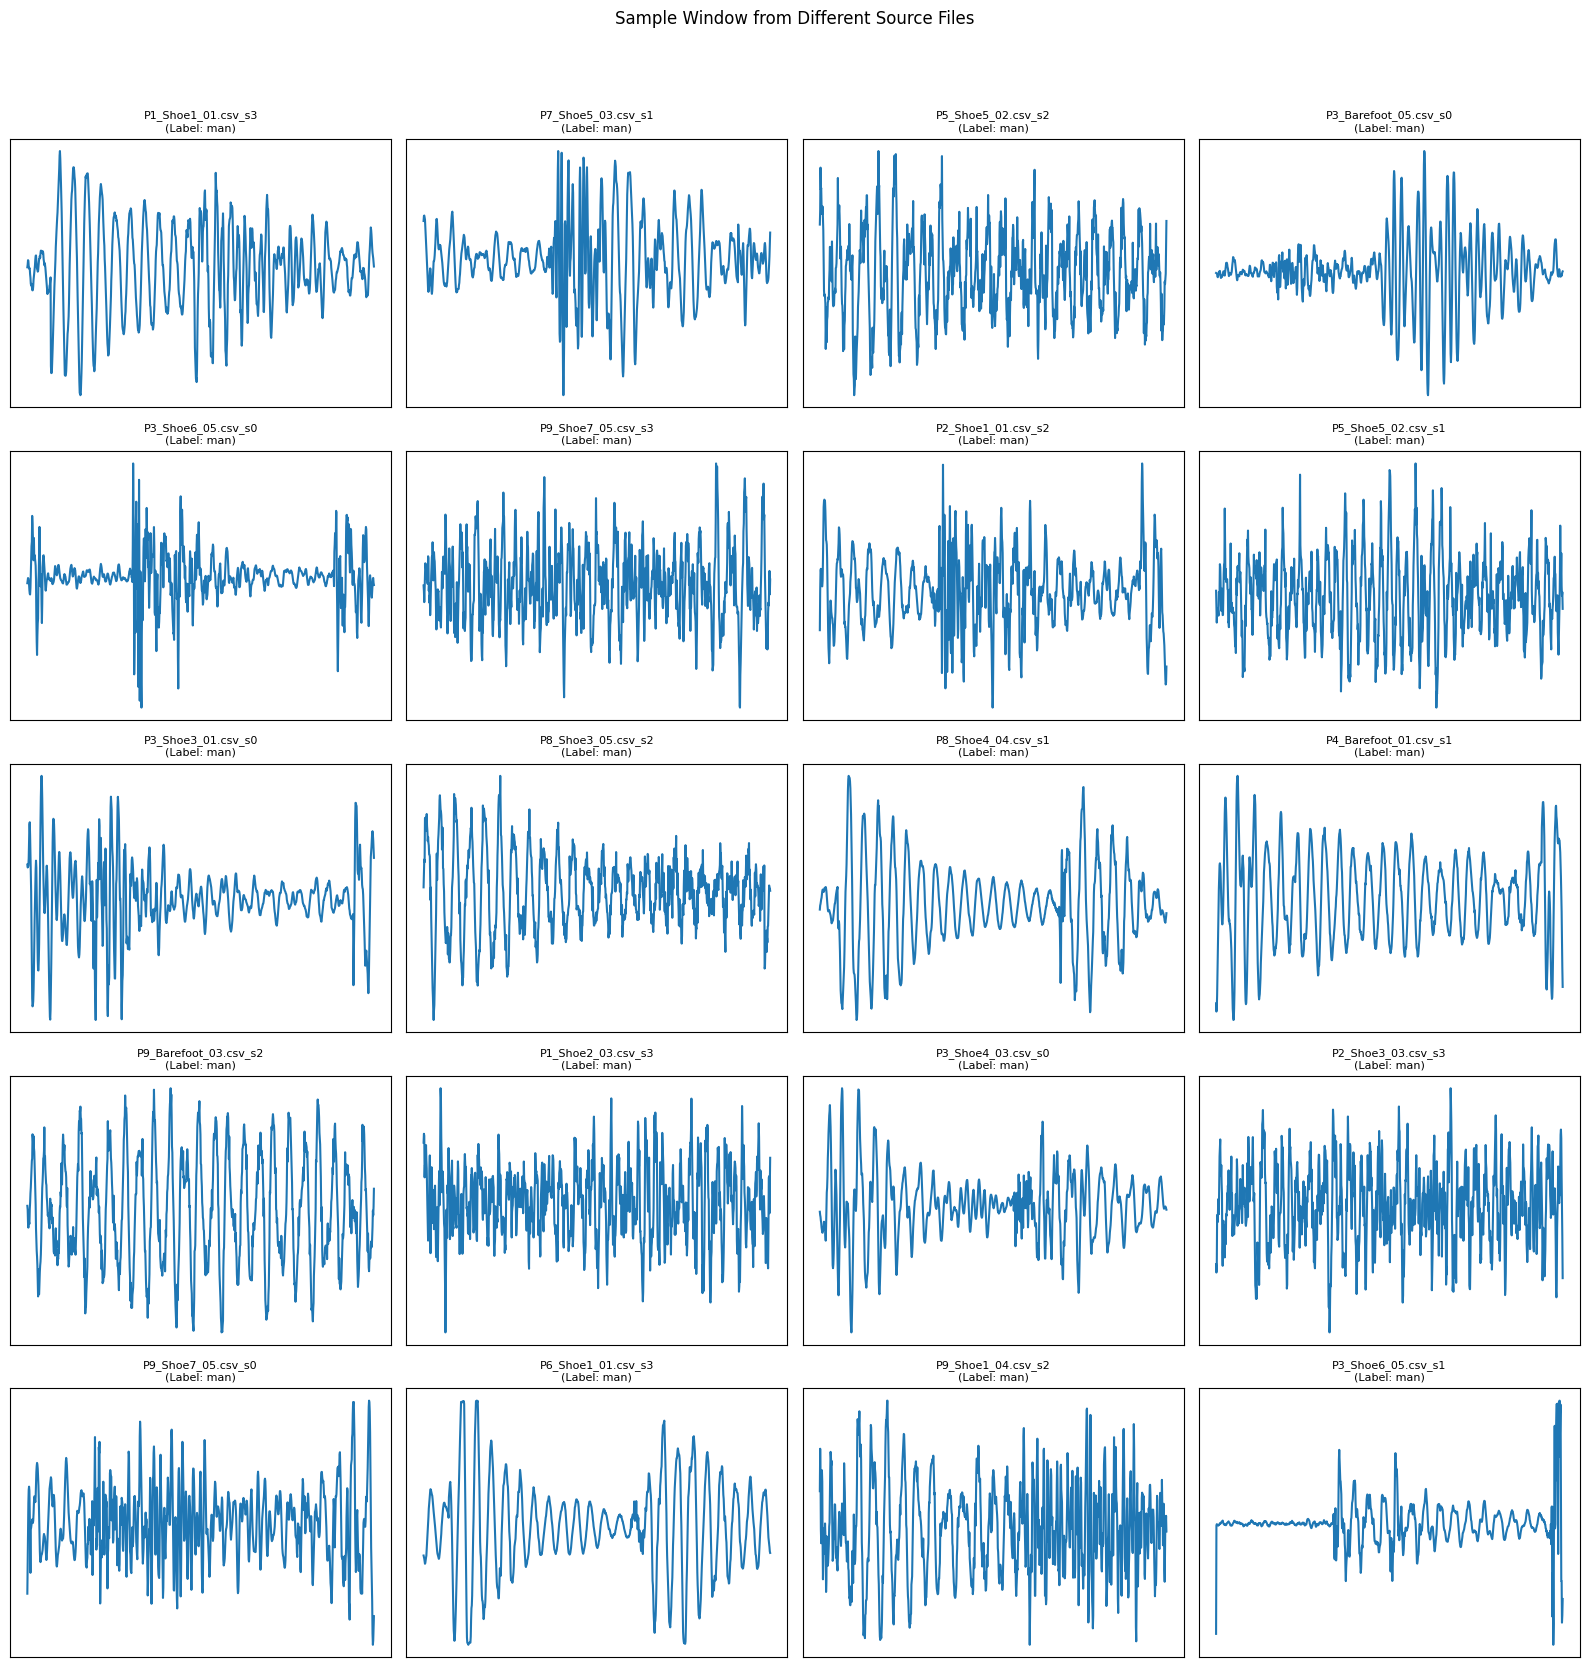


Plotting raw signal examples per CLASS...


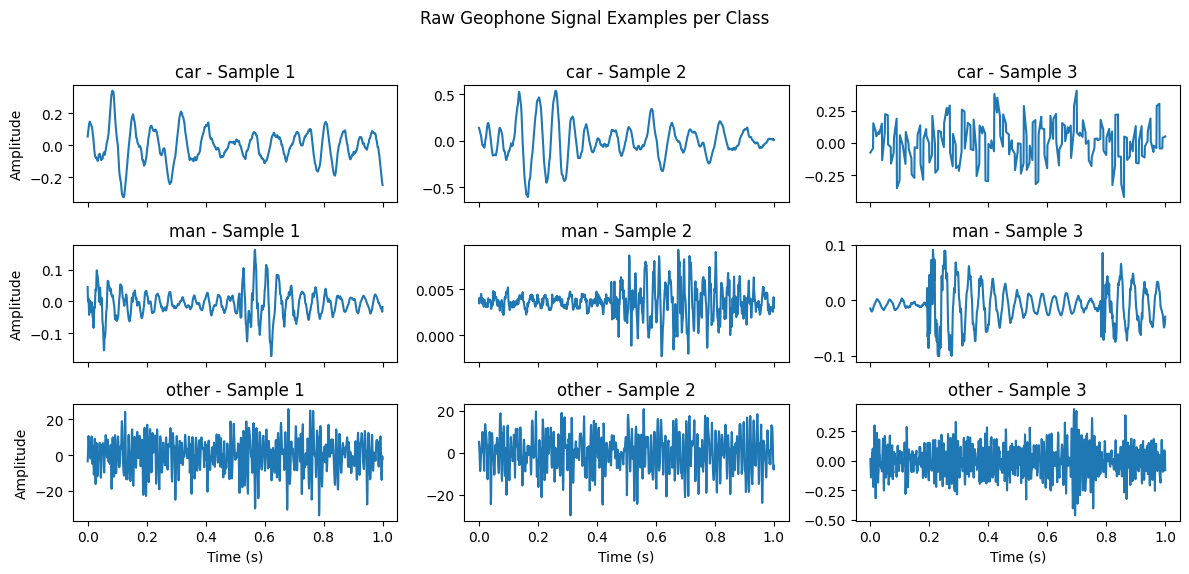


Plotting FFT examples per CLASS...


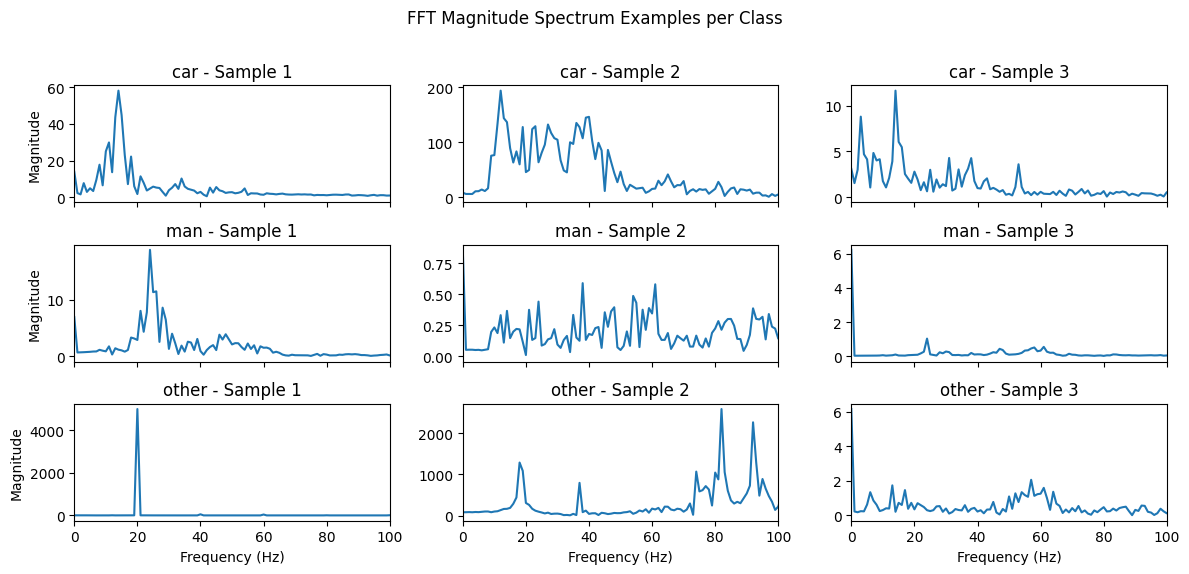


Model Architecture (3 Classes):
Total Trainable Parameters: 1,033,667

--- Starting Training (3 Classes with Aggressive Aug for 'other') ---


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/60] - Train Loss: 0.5743, Acc: 0.8691 | Val Loss: 0.3813, Acc: 0.9034 | LR: 0.000100
Epoch [2/60] - Train Loss: 0.4200, Acc: 0.8948 | Val Loss: 0.3351, Acc: 0.9167 | LR: 0.000100
Epoch [3/60] - Train Loss: 0.3870, Acc: 0.8960 | Val Loss: 0.3237, Acc: 0.9267 | LR: 0.000100
Epoch [4/60] - Train Loss: 0.3733, Acc: 0.8912 | Val Loss: 0.3107, Acc: 0.9259 | LR: 0.000100
Epoch [5/60] - Train Loss: 0.3482, Acc: 0.8955 | Val Loss: 0.2981, Acc: 0.9227 | LR: 0.000100
Epoch [6/60] - Train Loss: 0.3727, Acc: 0.8866 | Val Loss: 0.2896, Acc: 0.9239 | LR: 0.000100
Epoch [7/60] - Train Loss: 0.3231, Acc: 0.9002 | Val Loss: 0.2879, Acc: 0.9294 | LR: 0.000100
Epoch [8/60] - Train Loss: 0.3193, Acc: 0.9039 | Val Loss: 0.2826, Acc: 0.9315 | LR: 0.000100
Epoch [9/60] - Train Loss: 0.3155, Acc: 0.8935 | Val Loss: 0.2787, Acc: 0.9207 | LR: 0.000100
Epoch [10/60] - Train Loss: 0.3035, Acc: 0.9015 | Val Loss: 0.2836, Acc: 0.9275 | LR: 0.000100
Epoch [11/60] - Train Loss: 0.3035, Acc: 0.8985 | Val Loss:

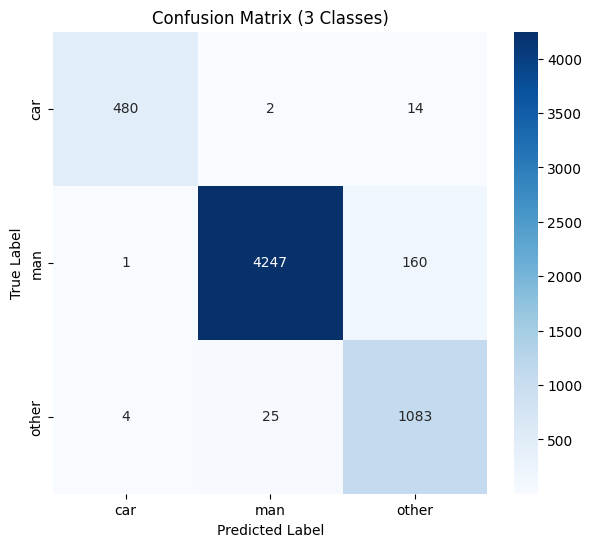


Plotting training history...


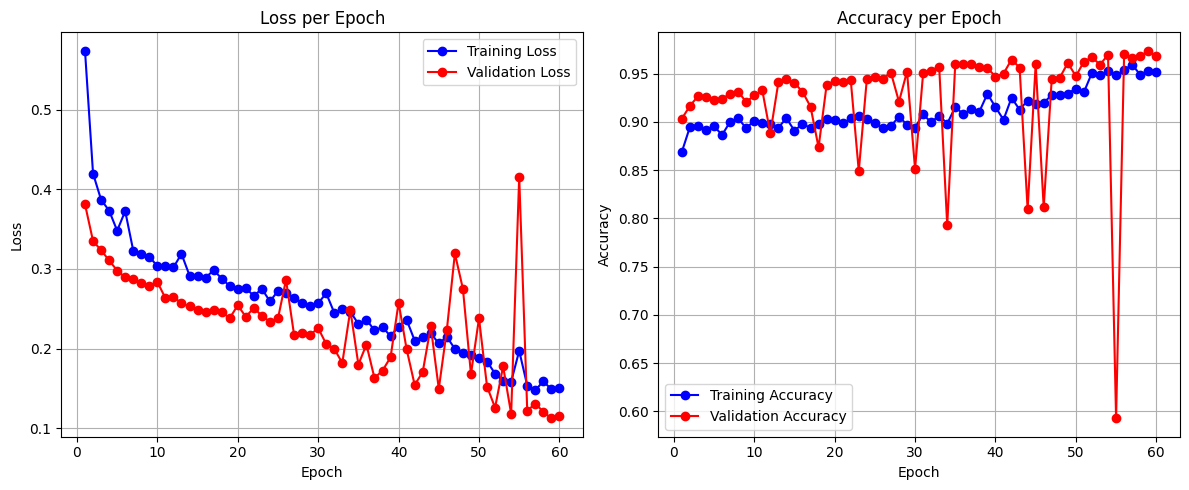


--- Script Finished ---


In [43]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import os
import glob
from collections import Counter, defaultdict
import time
import math
import random
import traceback

# --- Configuration ---
BASE_DATA_DIR = 'DATA' # Base directory containing all CSVs (including new 'other' files)
MAN2_FOLDER_NAME = 'man2' # Subdirectory for additional 'man' files
# --- !!! NEW: Directory for the new 'other' files !!! ---
# Assuming you moved all new CSVs (aircraft, commute etc.) into a folder named 'OTHER' inside 'DATA'
OTHER_FOLDER_NAME = 'OTHER'
# ----------------------------------------------------------

# Using Original Sampling Rate
TARGET_SAMPLING_RATE = 1000.0

# Parameters based on TARGET_SAMPLING_RATE
WINDOW_SECONDS = 1.0
STEP_SECONDS = 0.5
WINDOW_SIZE = int(TARGET_SAMPLING_RATE * WINDOW_SECONDS) # 1000
STEP_SIZE = int(TARGET_SAMPLING_RATE * STEP_SECONDS)     # 500

# Model & Training Params
BATCH_SIZE = 128
LEARNING_RATE = 0.0001 # Reduced LR
GRADIENT_CLIP_VALUE = 1.0 # Grad Clip
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.5
NUM_EPOCHS = 60 # Allow more epochs
VALIDATION_SPLIT_RATIO = 0.15
TEST_SPLIT_RATIO = 0.15
EARLY_STOPPING_PATIENCE = 10
LR_SCHEDULER_PATIENCE = 5
LR_SCHEDULER_FACTOR = 0.1

# Augmentation Params
AUGMENT_GAUSSIAN_STD = 0.01
AUGMENT_AMPLITUDE_RANGE = (0.9, 1.1)
AUGMENT_TIME_SHIFT_MAX_FRACTION = 0.1
AUGMENT_OTHER_GAUSSIAN_STD = 0.05
AUGMENT_OTHER_AMPLITUDE_RANGE = (0.7, 1.3)
AUGMENT_OTHER_TIME_SHIFT_MAX_FRACTION = 0.2

# Other Settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
# Define ALL classes
ALL_CLASSES = ['man', 'car', 'other']
OTHER_LABEL_STR = 'other'

# --- Setup Reproducibility ---
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
print(f"Using device: {DEVICE}")
print(f"Target Sampling Rate (Hz): {TARGET_SAMPLING_RATE}")
print(f"Window Size (samples): {WINDOW_SIZE}")
print(f"Classes: {ALL_CLASSES}")
print(f"Base Data Directory: {BASE_DATA_DIR}")
print(f"Using Aggressive Augmentation for '{OTHER_LABEL_STR}' class.")

# --- Data Loading ---
def load_data_from_file(filepath):
    """Loads data from a single CSV file."""
    try:
        df = pd.read_csv(filepath, header=None)
        if df.shape[1] == 0: print(f"    Warning: File {filepath} has no columns."); return None
        df.fillna(0.0, inplace=True) # Replace NaNs with 0
        return df.values.astype(np.float32)
    except pd.errors.EmptyDataError: print(f"    Warning: File {filepath} is empty."); return None
    except Exception as e: print(f"    Error loading {filepath}: {e}"); return None

# --- Function to Load and Create Windows (No Resampling) ---
def process_file_no_resample(filepath, label, window_size, step_size, label_encoder):
    """Loads data and creates windows without resampling."""
    print(f"  Processing file: {os.path.basename(filepath)} (Label: {label})...")
    file_windows, file_labels, file_sources = [], [], [] # Use local lists for this file
    try:
        original_data = load_data_from_file(filepath)
        if original_data is None or original_data.shape[0] < window_size: return [], [], []

        num_sensors, num_samples = original_data.shape[1], original_data.shape[0]
        label_idx = label_encoder.transform([label])[0]
        base_filename = os.path.basename(filepath)

        for sensor_idx in range(num_sensors):
            sensor_data = original_data[:, sensor_idx]
            if np.isnan(sensor_data).any() or np.isinf(sensor_data).any():
                print(f"    Warning: NaN/Inf found in sensor {sensor_idx} of {base_filename}. Cleaning.")
                sensor_data = np.nan_to_num(sensor_data, nan=0.0, posinf=0.0, neginf=0.0)

            for start in range(0, num_samples - window_size + 1, step_size):
                window = sensor_data[start:start + window_size]
                if not np.isnan(window).any() and not np.isinf(window).any():
                    file_windows.append(window.reshape(1, -1)) # Add channel dim
                    file_labels.append(label_idx)
                    file_sources.append(f"{base_filename}_s{sensor_idx}")

        print(f"    Created {len(file_windows)} windows for this file.")
        return file_windows, file_labels, file_sources

    except Exception as e:
        print(f"    Error processing file {filepath}: {e}")
        traceback.print_exc()
        return [], [], []

# --- Load All Files, Create Windows, Assign Labels ---
all_windows_list = []
all_labels_list = []
all_sources_list = []
label_encoder_3class = LabelEncoder().fit(ALL_CLASSES)
other_class_index = label_encoder_3class.transform([OTHER_LABEL_STR])[0]

# Define file lists for each category
man_files = ['man.csv']
car_files = ['car.csv', 'car2.csv', 'car3.csv', 'car4.csv']
# Original 'other' files
original_other_files = ['nothing.csv', 'noise.csv']
# New 'other' files assumed to be in DATA/OTHER folder
new_other_dir = os.path.join(BASE_DATA_DIR, OTHER_FOLDER_NAME)
new_other_files = []
if os.path.isdir(new_other_dir):
    print(f"\nLooking for new 'other' files in {new_other_dir}...")
    new_other_files = glob.glob(os.path.join(new_other_dir, '*.csv'))
    print(f"  Found {len(new_other_files)} potential new 'other' files.")
else:
    print(f"Warning: Directory for new 'other' files not found: {new_other_dir}")

# Process 'man' files
print("\n--- Processing 'man' Data Files ---")
for fname in man_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_no_resample(filepath, 'man', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)
# Process 'man2' files
man2_dir_path = os.path.join(BASE_DATA_DIR, MAN2_FOLDER_NAME)
if os.path.isdir(man2_dir_path):
    man2_csvs = glob.glob(os.path.join(man2_dir_path, '*.csv'))
    print(f"\n--- Processing 'man2' Data Files ({len(man2_csvs)} files) ---")
    for filepath in man2_csvs:
        windows, labels, sources = process_file_no_resample(filepath, 'man', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)

# Process 'car' files
print("\n--- Processing 'car' Data Files ---")
for fname in car_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_no_resample(filepath, 'car', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)

# Process 'other' files (Original + New)
print("\n--- Processing 'other' Data Files ---")
# Process original other files
for fname in original_other_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_no_resample(filepath, 'other', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)
    else: print(f"  Warning: Original 'other' file not found - {filepath}")
# Process new other files
if new_other_files:
    print("\n--- Processing NEW 'other' Data Files ---")
    for filepath in new_other_files:
         # Assuming all files in OTHER folder should be labeled 'other'
        windows, labels, sources = process_file_no_resample(filepath, 'other', WINDOW_SIZE, STEP_SIZE, label_encoder_3class)
        all_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)


# Convert lists to numpy arrays
if all_windows_list:
     all_windows_np = np.stack(all_windows_list, axis=0).astype(np.float32)
else: all_windows_np = np.empty((0, 1, WINDOW_SIZE), dtype=np.float32)
all_labels_np = np.array(all_labels_list, dtype=np.int64) if all_labels_list else np.empty(0, dtype=np.int64)
print(f"\nTotal windows from all sources: {len(all_windows_np)}")
if len(all_windows_np) > 0:
    print(f"Shape of final window data: {all_windows_np.shape}")
    print(f"Shape of final label data: {all_labels_np.shape}")
else: print("Warning: No windows created from any files.")


# --- Analyze Window Distribution (Corrected Function) ---
def print_window_summary(split_name, y_labels, encoder):
    """Prints the distribution of labels (windows) in a dataset split."""
    if isinstance(y_labels, (np.ndarray, list)) and len(y_labels) == 0: counts = {}; total = 0
    elif isinstance(y_labels, np.ndarray): counts = Counter(y_labels); total = len(y_labels)
    elif isinstance(y_labels, list): counts = Counter(y_labels); total = len(y_labels)
    else: print(f"Warning: Unexpected type for labels in {split_name}: {type(y_labels)}."); return
    if total == 0: print(f"  {split_name}: No windows generated."); return
    summary = []; [summary.append(f'{class_name}: {counts.get(i, 0)}') for i, class_name in enumerate(encoder.classes_)]
    print(f"  {split_name} (Total: {total}):   [{', '.join(summary)}]")

print("\nLabel distribution in combined data:")
if len(all_labels_np) > 0: print_window_summary("Combined", all_labels_np, label_encoder_3class)
else: print("  Combined: No windows generated.")


# --- Split Combined Data into Train/Val/Test ---
if len(all_windows_np) > 0:
    try:
        indices = np.arange(len(all_windows_np))
        min_samples_per_class = Counter(all_labels_np).most_common()[-1][1] if Counter(all_labels_np) else 0
        n_splits_required = 2
        if min_samples_per_class < n_splits_required: raise ValueError(f"Min samples per class ({min_samples_per_class}) < {n_splits_required}")
        train_val_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT_RATIO, stratify=all_labels_np, random_state=SEED)
        min_samples_train_val = Counter(all_labels_np[train_val_idx]).most_common()[-1][1] if Counter(all_labels_np[train_val_idx]) else 0
        if min_samples_train_val < n_splits_required: raise ValueError(f"Min samples per class in train/val ({min_samples_train_val}) < {n_splits_required}")
        val_split_ratio_adj = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO)
        train_idx, val_idx = train_test_split(train_val_idx, test_size=val_split_ratio_adj, stratify=all_labels_np[train_val_idx], random_state=SEED)
        X_train = all_windows_np[train_idx]; y_train = all_labels_np[train_idx]; sources_train = [all_sources_list[i] for i in train_idx]
        X_val = all_windows_np[val_idx]; y_val = all_labels_np[val_idx]; sources_val = [all_sources_list[i] for i in val_idx]
        X_test = all_windows_np[test_idx]; y_test = all_labels_np[test_idx]; sources_test = [all_sources_list[i] for i in test_idx]
    except ValueError as e: # Catch explicit error or fallback from stratification check
        print(f"\nWarning: Stratified split failed ({e}). Falling back to non-stratified split.")
        indices = np.arange(len(all_windows_np)); train_val_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT_RATIO, random_state=SEED)
        val_split_ratio_adj = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO); train_idx, val_idx = train_test_split(train_val_idx, test_size=val_split_ratio_adj, random_state=SEED)
        X_train = all_windows_np[train_idx]; y_train = all_labels_np[train_idx]; sources_train = [all_sources_list[i] for i in train_idx]
        X_val = all_windows_np[val_idx]; y_val = all_labels_np[val_idx]; sources_val = [all_sources_list[i] for i in val_idx]
        X_test = all_windows_np[test_idx]; y_test = all_labels_np[test_idx]; sources_test = [all_sources_list[i] for i in test_idx]
else: raise ValueError("No windows available for splitting.")


# --- Analyze Window Distribution per Set ---
print("\nWindow Distribution per Split Set:")
print_window_summary("Training", y_train, label_encoder_3class)
print_window_summary("Validation", y_val, label_encoder_3class)
print_window_summary("Test", y_test, label_encoder_3class)

# Critical Check for Empty Sets
if len(X_train) == 0: raise ValueError("CRITICAL ERROR: Training set empty after split!")
if len(X_val) == 0: print("\nWARNING: Validation set empty after split!")
if len(X_test) == 0: print("\nWARNING: Test set empty after split!")


# --- Calculate Class Weights (for 3 classes) ---
if len(y_train) > 0:
    class_counts = np.bincount(y_train, minlength=len(ALL_CLASSES))
    total_samples = len(y_train)
    class_weights = total_samples / (len(class_counts) * class_counts + 1e-6)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    print(f"\nCalculated Class Weights (3 Classes): {class_weights_tensor.cpu().numpy()}")
    for i, cls_name in enumerate(label_encoder_3class.classes_):
        count_str = str(class_counts[i]) if i < len(class_counts) else "N/A"; weight_str = f"{class_weights[i]:.4f}" if i < len(class_weights) else "N/A"
        print(f"  Weight for '{cls_name}': {weight_str} (Count: {count_str})")
else: print("\nWarning: Training set empty."); class_weights_tensor = torch.ones(len(ALL_CLASSES), dtype=torch.float).to(DEVICE)

# --- PyTorch Dataset with Conditional Augmentation ---
class GeophoneAugmentedDataset(Dataset):
    # (Definition remains the same)
    def __init__(self, features, labels, source_files, window_size, augment=False, other_idx=None):
        self.is_empty = features.size == 0 if isinstance(features, np.ndarray) else (len(features) == 0)
        if self.is_empty: self.features_np = np.empty((0, window_size)); self.labels_np = np.empty(0, dtype=np.int64); self.source_files = []
        else:
            self.features_np = features; self.labels_np = labels; self.source_files = source_files
            if self.features_np.ndim == 3 and self.features_np.shape[1] == 1: self.features_np = np.squeeze(self.features_np, axis=1)
            elif self.features_np.ndim != 2: raise ValueError(f"Unsupported feature dimensions: {self.features_np.shape}")
        self.window_size = window_size; self.augment = augment; self.other_idx = other_idx
    def __len__(self): return len(self.labels_np) if not self.is_empty else 0
    def __getitem__(self, idx):
        if self.is_empty: raise IndexError("Dataset is empty")
        if self.features_np.ndim != 2: raise ValueError(f"Features array incorrect dims: {self.features_np.shape}")
        signal = self.features_np[idx].copy(); label = self.labels_np[idx]; source = self.source_files[idx] if idx < len(self.source_files) else "N/A" # Safety check for source_files length
        if self.augment:
            is_other = (self.other_idx is not None and label == self.other_idx)
            amp_range = AUGMENT_OTHER_AMPLITUDE_RANGE if is_other else AUGMENT_AMPLITUDE_RANGE
            gauss_std = AUGMENT_OTHER_GAUSSIAN_STD if is_other else AUGMENT_GAUSSIAN_STD
            shift_frac = AUGMENT_OTHER_TIME_SHIFT_MAX_FRACTION if is_other else AUGMENT_TIME_SHIFT_MAX_FRACTION
            max_shift = int(self.window_size * shift_frac)
            if max_shift > 0 : shift = random.randint(-max_shift, max_shift); signal = np.roll(signal, shift) if shift != 0 else signal
            scale_factor = random.uniform(amp_range[0], amp_range[1]); signal = signal * scale_factor
            if gauss_std > 0:
                 signal_std_val = np.std(signal)
                 if signal_std_val > 1e-9: noise_std = gauss_std * signal_std_val; noise = np.random.normal(0, noise_std, signal.shape); signal = signal + noise
        signal_tensor = torch.from_numpy(signal).float().unsqueeze(0); label_tensor = torch.tensor(label, dtype=torch.long)
        return signal_tensor, label_tensor, source

# Create Datasets
train_dataset = GeophoneAugmentedDataset(X_train, y_train, sources_train, WINDOW_SIZE, augment=True, other_idx=other_class_index)
val_dataset = GeophoneAugmentedDataset(X_val, y_val, sources_val, WINDOW_SIZE, augment=False)
test_dataset = GeophoneAugmentedDataset(X_test, y_test, sources_test, WINDOW_SIZE, augment=False)

# --- PyTorch DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nUsing standard shuffling for Training DataLoader.")
print(f"DataLoaders created. Batches per epoch (Train): {len(train_loader)}")


# --- Visualization Functions (Full Definitions) ---
def plot_samples_per_file(dataset, label_encoder, n_samples_per_file=1, max_files_to_plot=20):
    """Plots example windows, one from each unique source file."""
    print(f"\nPlotting samples per source file (max {max_files_to_plot} files)...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    indices_by_source = defaultdict(list)
    if not hasattr(dataset, 'source_files') or not dataset.source_files: print("  No source file info."); return
    for i, source_file in enumerate(dataset.source_files): indices_by_source[source_file].append(i)
    unique_files = list(indices_by_source.keys()); random.shuffle(unique_files) # Shuffle for variety
    if len(unique_files) > max_files_to_plot: plot_files = unique_files[:max_files_to_plot]
    else: plot_files = unique_files
    n_files = len(plot_files);
    if n_files == 0: print("  No files found."); return
    cols = min(4, n_files); rows = math.ceil(n_files / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5), squeeze=False); fig.suptitle('Sample Window from Different Source Files')
    axs = axs.flatten()
    time_axis = np.linspace(0, WINDOW_SECONDS, dataset.window_size)
    plot_idx = 0
    for i, filename in enumerate(plot_files):
        if plot_idx >= len(axs): break
        file_indices = indices_by_source[filename]; sample_indices = random.sample(file_indices, min(n_samples_per_file, len(file_indices)))
        if sample_indices:
            idx = sample_indices[0];
            try: # Add try-except for __getitem__ call
                 signal, label_idx, _ = dataset[idx];
                 signal = signal.squeeze().cpu().numpy(); label_name = label_encoder.classes_[label_idx.item()]
                 axs[plot_idx].plot(time_axis, signal); axs[plot_idx].set_title(f"{filename}\n(Label: {label_name})", fontsize=8); axs[plot_idx].set_xticks([]); axs[plot_idx].set_yticks([]); plot_idx += 1
            except Exception as e:
                 print(f"Error getting/plotting sample {idx} from {filename}: {e}")
    for j in range(plot_idx, len(axs)): axs[j].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def plot_raw_signals(dataset, label_encoder, n_samples=3):
    """Plots raw signal examples for each class (uses original numpy data)."""
    print("\nPlotting raw signal examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_); fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 2), sharex=True, squeeze=False); fig.suptitle('Raw Geophone Signal Examples per Class')
    time_axis = np.linspace(0, WINDOW_SECONDS, dataset.window_size); all_labels_np = dataset.labels_np
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                 if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples', ha='center', va='center'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
             if i < axs.shape[0] and j < axs.shape[1]:
                signal_np = dataset.features_np[sample_idx] # Use original numpy signal
                axs[i, j].plot(time_axis, signal_np); axs[i, j].set_title(f"{class_name} - Sample {j+1}")
                if i == num_classes - 1: axs[i, j].set_xlabel('Time (s)')
                if j == 0: axs[i, j].set_ylabel('Amplitude')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

def plot_fft_signals(dataset, label_encoder, n_samples=3):
    """Plots FFT magnitude spectrum examples for each class (uses original numpy data)."""
    print("\nPlotting FFT examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_); fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 2), sharex=True, squeeze=False); fig.suptitle('FFT Magnitude Spectrum Examples per Class')
    freq_axis = np.fft.rfftfreq(dataset.window_size, 1.0/TARGET_SAMPLING_RATE); all_labels_np = dataset.labels_np
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples', ha='center', va='center'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
            if i < axs.shape[0] and j < axs.shape[1]:
                signal_np = dataset.features_np[sample_idx] # Use original numpy signal
                fft_vals = np.fft.rfft(signal_np); fft_mag = np.abs(fft_vals); axs[i, j].plot(freq_axis, fft_mag)
                axs[i, j].set_title(f"{class_name} - Sample {j+1}");
                if i == num_classes - 1: axs[i, j].set_xlabel('Frequency (Hz)')
                if j == 0: axs[i, j].set_ylabel('Magnitude')
                axs[i,j].set_xlim(0, TARGET_SAMPLING_RATE / 10) # Show up to 100Hz
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

# --- Plot initial visualizations ---
if len(train_dataset) > 0:
    plot_samples_per_file(train_dataset, label_encoder_3class)
    plot_raw_signals(train_dataset, label_encoder_3class)
    plot_fft_signals(train_dataset, label_encoder_3class)
else: print("\nTraining dataset empty, skipping initial visualizations.")

# --- Model Definition (3 classes) ---
class Simple1DCNN_3Class(nn.Module):
    # (Definition remains the same)
    def __init__(self, num_classes, window_size, dropout_rate):
        super(Simple1DCNN_3Class, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv1d(1, 16, 7, 1, 3), nn.BatchNorm1d(16), nn.ReLU(), nn.MaxPool1d(2, 2))
        self.conv_block2 = nn.Sequential(nn.Conv1d(16, 32, 5, 1, 2), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2, 2))
        self.conv_block3 = nn.Sequential(nn.Conv1d(32, 64, 3, 1, 1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2, 2))
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, window_size); dummy_output = self.conv_block3(self.conv_block2(self.conv_block1(dummy_input)))
            self.flattened_size = dummy_output.numel();
            if self.flattened_size <= 0 : raise ValueError(f"Flattened size invalid: {self.flattened_size}.")
        self.fc_block = nn.Sequential(nn.Flatten(), nn.Linear(self.flattened_size, 128), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.conv_block1(x); x = self.conv_block2(x); x = self.conv_block3(x); x = self.fc_block(x); return x

# Instantiate the model
model = Simple1DCNN_3Class(num_classes=len(ALL_CLASSES), window_size=WINDOW_SIZE, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("\nModel Architecture (3 Classes):")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

# --- Training Setup ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)

# --- Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf'); epochs_no_improve = 0; best_model_state = None
run_validation = len(val_dataset) > 0
if not run_validation: best_val_loss = -1

print("\n--- Starting Training (3 Classes with Aggressive Aug for 'other') ---")
start_time = time.time()
# (Training loop remains the same)
for epoch in range(NUM_EPOCHS):
    model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
    for i, batch_data in enumerate(train_loader):
        if len(batch_data) == 3: inputs, labels, _ = batch_data
        elif len(batch_data) == 2: inputs, labels = batch_data
        else: raise ValueError(f"Unexpected batch structure: {batch_data}")
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0
    history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)
    epoch_val_loss, epoch_val_acc = float('nan'), float('nan')
    if run_validation:
        model.eval(); running_val_loss = 0.0; correct_val = 0; total_val = 0
        with torch.no_grad():
            for batch_data in val_loader:
                if len(batch_data) == 3: inputs, labels, _ = batch_data
                elif len(batch_data) == 2: inputs, labels = batch_data
                else: raise ValueError(f"Unexpected batch structure: {batch_data}")
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs); loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0); correct_val += (predicted == labels).sum().item()
        epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0
        epoch_val_acc = correct_val / total_val if total_val > 0 else 0
        history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        if not math.isnan(epoch_val_loss):
             scheduler.step(epoch_val_loss)
             if epoch_val_loss < best_val_loss:
                 best_val_loss = epoch_val_loss; epochs_no_improve = 0; best_model_state = model.state_dict()
             else: epochs_no_improve += 1
             if epochs_no_improve >= EARLY_STOPPING_PATIENCE: print(f"\nEarly stopping triggered after {epoch+1} epochs."); break
        else: pass
    else:
        history['val_loss'].append(float('nan')); history['val_acc'].append(float('nan'))
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | (No Validation)")
        best_model_state = model.state_dict()
end_time = time.time()
print(f"\n--- Training Finished ---"); print(f"Total Training Time: {end_time - start_time:.2f} seconds")

# --- Save the 3-class model ---
SAVED_MODEL_PATH = "geophone_model_3class_final_all_other.pth" # Updated name
if best_model_state is not None:
    if run_validation and best_val_loss != float('inf'): print(f"Saving best model state (Val Loss: {best_val_loss:.4f}) to {SAVED_MODEL_PATH}")
    else: print(f"Saving last model state to {SAVED_MODEL_PATH}")
    torch.save(best_model_state, SAVED_MODEL_PATH)
else:
    print(f"Warning: No model state saved. Saving current model to {SAVED_MODEL_PATH}")
    torch.save(model.state_dict(), SAVED_MODEL_PATH)


# --- Load the saved 3-class model for evaluation ---
print(f"\n--- Loading Saved 3-Class Model from {SAVED_MODEL_PATH} for Evaluation ---")
eval_model = Simple1DCNN_3Class(num_classes=len(ALL_CLASSES), window_size=WINDOW_SIZE, dropout_rate=DROPOUT_RATE)
try:
    eval_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE)); eval_model.to(DEVICE); eval_model.eval()
    print("Model loaded successfully for evaluation.")
except Exception as e: print(f"Error loading model: {e}."); eval_model = None


# --- Evaluation on Test Set (3 Classes) ---
print(f"\n--- Evaluating on Test Set (3 Classes) ---")
if len(test_dataset) == 0: print("ERROR: Test set is empty.")
elif eval_model is None: print("ERROR: Model not loaded.")
else:
    all_preds_idx, all_true_idx = [], []
    with torch.no_grad():
        for batch_data in test_loader:
            if len(batch_data) == 3: inputs, labels, _ = batch_data
            elif len(batch_data) == 2: inputs, labels = batch_data
            else: raise ValueError(f"Unexpected batch structure: {batch_data}")
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE); outputs = eval_model(inputs)
            _, predicted = torch.max(outputs.data, 1); all_preds_idx.extend(predicted.cpu().numpy()); all_true_idx.extend(labels.cpu().numpy())
    if not all_true_idx: print("No samples processed.")
    else:
        test_accuracy = accuracy_score(all_true_idx, all_preds_idx); print(f"\nTest Accuracy (3 Classes): {test_accuracy:.4f}")
        present_labels = np.unique(np.concatenate((all_true_idx, all_preds_idx)))
        report = classification_report(all_true_idx, all_preds_idx, target_names=[label_encoder_3class.classes_[i] for i in present_labels], labels=present_labels, zero_division=0)
        print("\nClassification Report (Test Set):"); print(report)
        plt.figure(figsize=(7, 6)); cm = confusion_matrix(all_true_idx, all_preds_idx, labels=np.arange(len(ALL_CLASSES)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_3class.classes_, yticklabels=label_encoder_3class.classes_)
        plt.title('Confusion Matrix (3 Classes)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

# --- Final Visualizations ---
def plot_training_history_adj(history):
    """Plots training and validation loss and accuracy, handles missing val data."""
    print("\nPlotting training history...")
    if not history or not history.get('train_loss'): print("  No training history data."); return
    fig, axs = plt.subplots(1, 2, figsize=(12, 5)); epochs = range(1, len(history['train_loss']) + 1)
    axs[0].plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    if history.get('val_loss') and any(x is not None and not math.isnan(x) for x in history['val_loss']): axs[0].plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    axs[0].set_title('Loss per Epoch'); axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].grid(True)
    axs[1].plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    if history.get('val_acc') and any(x is not None and not math.isnan(x) for x in history['val_acc']): axs[1].plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    axs[1].set_title('Accuracy per Epoch'); axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Accuracy'); axs[1].legend(); axs[1].grid(True)
    plt.tight_layout(); plt.show()

if 'history' in locals() and history.get('train_loss'): plot_training_history_adj(history)
else: print("\nNo training performed or history not available.")

print("\n--- Script Finished ---")

Using device: cuda
Sampling Rate (Hz): 1000.0
Time Window Size (samples): 1000
Classes: ['man', 'car', 'other']
Using Mel-Spectrograms (n_fft=512, hop_length=128, n_mels=64)
Optimizer: AdamW, LR: 0.0001, Weight Decay: 0.001
Batch Size: 128, Label Smoothing: 0.1
Using Aggressive Augmentation for 'other' class.

--- Processing 'man' Data Files -> Time Windows ---
  Processing file: man.csv (Label: man)...
    Created 2479 time windows.

--- Processing 'man2' Data Files (354 files) -> Time Windows ---
  Processing file: P1_Barefoot_01.csv (Label: man)...
    Created 76 time windows.
  Processing file: P1_Barefoot_02.csv (Label: man)...
    Created 76 time windows.
  Processing file: P1_Barefoot_03.csv (Label: man)...
    Created 76 time windows.
  Processing file: P1_Barefoot_04.csv (Label: man)...
    Created 76 time windows.
  Processing file: P1_Barefoot_05.csv (Label: man)...
    Created 76 time windows.
  Processing file: P1_Shoe1_01.csv (Label: man)...
    Created 76 time windows.
 

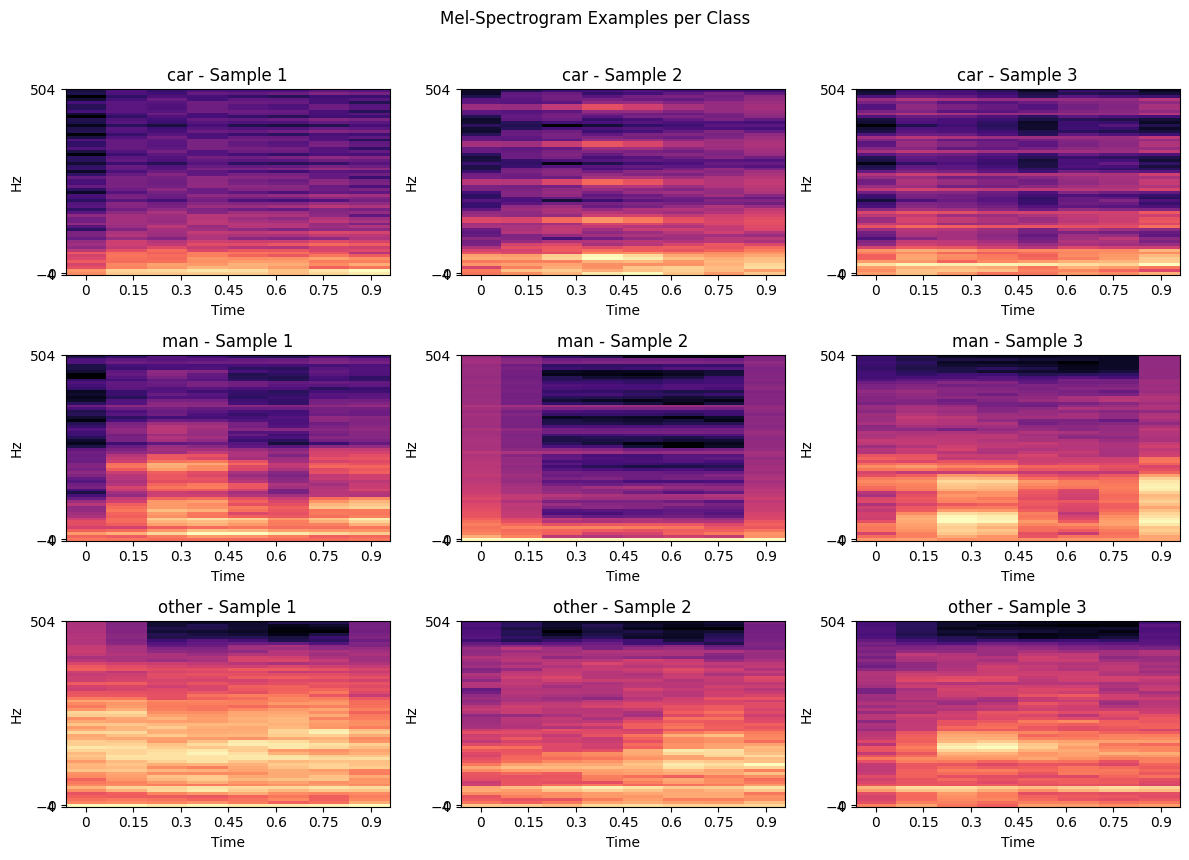

Input Spectrogram dimensions for CNN: Height=64, Width=8

Model Architecture (2D CNN):
Total Trainable Parameters: 89,571

--- Starting Training (3 Classes, Spectrograms, 2D CNN) ---


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import os
import glob
from collections import Counter, defaultdict
import time
import math
import random
import traceback
import librosa # *** Import librosa ***
import librosa.display # For displaying spectrograms

# --- Configuration ---
BASE_DATA_DIR = 'DATA'
MAN2_FOLDER_NAME = 'man2'
OTHER_FOLDER_NAME = 'OTHER'

# Sampling Rate (Original rate of the CSV files)
TARGET_SAMPLING_RATE = 1000.0

# Parameters based on TARGET_SAMPLING_RATE
WINDOW_SECONDS = 1.0
STEP_SECONDS = 0.5
WINDOW_SIZE_TIME = int(TARGET_SAMPLING_RATE * WINDOW_SECONDS) # Samples in time domain window (1000)
STEP_SIZE_TIME = int(TARGET_SAMPLING_RATE * STEP_SECONDS)     # Step in time domain (500)

# Mel-Spectrogram Parameters
N_FFT = 512
HOP_LENGTH = 128
N_MELS = 64
FMIN = 0
FMAX = TARGET_SAMPLING_RATE / 2

# Model & Training Params
BATCH_SIZE = 128 # Increased Batch Size
LEARNING_RATE = 0.0001 # Reduced LR
GRADIENT_CLIP_VALUE = 1.0
WEIGHT_DECAY = 1e-3 # Adjusted for AdamW
DROPOUT_RATE = 0.5
NUM_EPOCHS = 60
VALIDATION_SPLIT_RATIO = 0.15
TEST_SPLIT_RATIO = 0.15
EARLY_STOPPING_PATIENCE = 10
LR_SCHEDULER_PATIENCE = 5
LR_SCHEDULER_FACTOR = 0.1
LABEL_SMOOTHING = 0.1

# Augmentation Params
AUGMENT_GAUSSIAN_STD = 0.01
AUGMENT_AMPLITUDE_RANGE = (0.9, 1.1)
AUGMENT_TIME_SHIFT_MAX_FRACTION = 0.1
AUGMENT_OTHER_GAUSSIAN_STD = 0.05
AUGMENT_OTHER_AMPLITUDE_RANGE = (0.7, 1.3)
AUGMENT_OTHER_TIME_SHIFT_MAX_FRACTION = 0.2

# Other Settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
ALL_CLASSES = ['man', 'car', 'other']
OTHER_LABEL_STR = 'other'

# --- Setup Reproducibility ---
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
print(f"Using device: {DEVICE}")
print(f"Sampling Rate (Hz): {TARGET_SAMPLING_RATE}")
print(f"Time Window Size (samples): {WINDOW_SIZE_TIME}")
print(f"Classes: {ALL_CLASSES}")
print(f"Using Mel-Spectrograms (n_fft={N_FFT}, hop_length={HOP_LENGTH}, n_mels={N_MELS})")
print(f"Optimizer: AdamW, LR: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}")
print(f"Batch Size: {BATCH_SIZE}, Label Smoothing: {LABEL_SMOOTHING}")
print(f"Using Aggressive Augmentation for '{OTHER_LABEL_STR}' class.")


# --- Data Loading ---
def load_data_from_file(filepath):
    try:
        df = pd.read_csv(filepath, header=None)
        if df.shape[1] == 0: print(f"    Warning: File {filepath} has no columns."); return None
        df.fillna(0.0, inplace=True); return df.values.astype(np.float32)
    except pd.errors.EmptyDataError: print(f"    Warning: File {filepath} is empty."); return None
    except Exception as e: print(f"    Error loading {filepath}: {e}"); return None

# --- Function to Create Time Windows from a File ---
def process_file_to_time_windows(filepath, label, window_size, step_size, label_encoder):
    """Loads data and creates time-domain windows."""
    print(f"  Processing file: {os.path.basename(filepath)} (Label: {label})...")
    file_windows, file_labels, file_sources = [], [], []
    try:
        original_data = load_data_from_file(filepath)
        if original_data is None or original_data.shape[0] < window_size: return [], [], []
        num_sensors, num_samples = original_data.shape[1], original_data.shape[0]
        label_idx = label_encoder.transform([label])[0]
        base_filename = os.path.basename(filepath)
        windows_created_file = 0
        for sensor_idx in range(num_sensors):
            sensor_data = original_data[:, sensor_idx]
            if np.isnan(sensor_data).any() or np.isinf(sensor_data).any():
                sensor_data = np.nan_to_num(sensor_data, nan=0.0, posinf=0.0, neginf=0.0)
            for start in range(0, num_samples - window_size + 1, step_size):
                window = sensor_data[start:start + window_size]
                if not np.isnan(window).any() and not np.isinf(window).any():
                    # Store the 1D time window directly
                    file_windows.append(window)
                    file_labels.append(label_idx)
                    file_sources.append(f"{base_filename}_s{sensor_idx}_w{start}")
                    windows_created_file += 1
        print(f"    Created {windows_created_file} time windows.")
        return file_windows, file_labels, file_sources
    except Exception as e: print(f"    Error processing file {filepath}: {e}"); traceback.print_exc(); return [], [], []

# --- Load All Files, Create TIME WINDOWS, Assign Labels ---
all_time_windows_list = []
all_labels_list = []
all_sources_list = []
label_encoder_3class = LabelEncoder().fit(ALL_CLASSES)
other_class_index = label_encoder_3class.transform([OTHER_LABEL_STR])[0]

# Define file lists
man_files = ['man.csv']
car_files = ['car.csv', 'car2.csv', 'car3.csv', 'car4.csv']
original_other_files = ['nothing.csv', 'noise.csv']
new_other_dir = os.path.join(BASE_DATA_DIR, OTHER_FOLDER_NAME)
new_other_files = []
if os.path.isdir(new_other_dir): new_other_files = glob.glob(os.path.join(new_other_dir, '*.csv'))
else: print(f"Warning: Directory for new 'other' files not found: {new_other_dir}")

# Process 'man' files
print("\n--- Processing 'man' Data Files -> Time Windows ---")
for fname in man_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_to_time_windows(filepath, 'man', WINDOW_SIZE_TIME, STEP_SIZE_TIME, label_encoder_3class)
        all_time_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)
man2_dir_path = os.path.join(BASE_DATA_DIR, MAN2_FOLDER_NAME)
if os.path.isdir(man2_dir_path):
    man2_csvs = glob.glob(os.path.join(man2_dir_path, '*.csv'))
    print(f"\n--- Processing 'man2' Data Files ({len(man2_csvs)} files) -> Time Windows ---")
    for filepath in man2_csvs:
        windows, labels, sources = process_file_to_time_windows(filepath, 'man', WINDOW_SIZE_TIME, STEP_SIZE_TIME, label_encoder_3class)
        all_time_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)

# Process 'car' files
print("\n--- Processing 'car' Data Files -> Time Windows ---")
for fname in car_files:
    filepath = os.path.join(BASE_DATA_DIR, fname)
    if os.path.exists(filepath):
        windows, labels, sources = process_file_to_time_windows(filepath, 'car', WINDOW_SIZE_TIME, STEP_SIZE_TIME, label_encoder_3class)
        all_time_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)

# Process 'other' files
print("\n--- Processing 'other' Data Files -> Time Windows ---")
for fname in original_other_files + new_other_files: # Combine lists
    filepath = fname if os.path.isabs(fname) else os.path.join(BASE_DATA_DIR, fname) if fname in original_other_files else os.path.join(new_other_dir, os.path.basename(fname))
    if os.path.exists(filepath):
        windows, labels, sources = process_file_to_time_windows(filepath, 'other', WINDOW_SIZE_TIME, STEP_SIZE_TIME, label_encoder_3class)
        all_time_windows_list.extend(windows); all_labels_list.extend(labels); all_sources_list.extend(sources)
    else: print(f"  Warning: 'other' file not found - {filepath}")


# Convert lists to numpy arrays
if all_time_windows_list:
     all_windows_np_time = np.stack(all_time_windows_list, axis=0).astype(np.float32) # Shape (N, window_size_time)
else: all_windows_np_time = np.empty((0, WINDOW_SIZE_TIME), dtype=np.float32)
all_labels_np = np.array(all_labels_list, dtype=np.int64) if all_labels_list else np.empty(0, dtype=np.int64)
print(f"\nTotal time windows from all sources: {len(all_windows_np_time)}")
if len(all_windows_np_time) > 0:
    print(f"Shape of final time window data: {all_windows_np_time.shape}") # Should be (N, 1000)
    print(f"Shape of final label data: {all_labels_np.shape}")   # Should be (N,)
else: print("Warning: No time windows created.")


# --- Analyze Window Distribution ---
def print_window_summary(split_name, y_labels, encoder):
    # (Function definition remains the same)
    if isinstance(y_labels, (np.ndarray, list)) and len(y_labels) == 0: counts = {}; total = 0
    elif isinstance(y_labels, np.ndarray): counts = Counter(y_labels); total = len(y_labels)
    elif isinstance(y_labels, list): counts = Counter(y_labels); total = len(y_labels)
    else: print(f"Warning: Unexpected type for labels: {type(y_labels)}."); return
    if total == 0: print(f"  {split_name}: No windows generated."); return
    summary = []; [summary.append(f'{class_name}: {counts.get(i, 0)}') for i, class_name in enumerate(encoder.classes_)]
    print(f"  {split_name} (Total: {total}):   [{', '.join(summary)}]")

print("\nLabel distribution in combined data:")
if len(all_labels_np) > 0: print_window_summary("Combined", all_labels_np, label_encoder_3class)
else: print("  Combined: No windows generated.")


# --- Split Combined TIME Data into Train/Val/Test ---
if len(all_windows_np_time) > 0:
    try:
        indices = np.arange(len(all_windows_np_time))
        min_samples_per_class = Counter(all_labels_np).most_common()[-1][1] if Counter(all_labels_np) else 0; n_splits_required = 2
        if min_samples_per_class < n_splits_required: raise ValueError(f"Min samples per class ({min_samples_per_class}) < {n_splits_required}")
        # Split indices
        train_val_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT_RATIO, stratify=all_labels_np, random_state=SEED)
        min_samples_train_val = Counter(all_labels_np[train_val_idx]).most_common()[-1][1] if Counter(all_labels_np[train_val_idx]) else 0
        if min_samples_train_val < n_splits_required: raise ValueError(f"Min samples in train/val ({min_samples_train_val}) < {n_splits_required}")
        val_split_ratio_adj = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO)
        train_idx, val_idx = train_test_split(train_val_idx, test_size=val_split_ratio_adj, stratify=all_labels_np[train_val_idx], random_state=SEED)
        # Assign actual time-domain data and labels based on indices
        X_train_time = all_windows_np_time[train_idx]; y_train = all_labels_np[train_idx]; sources_train = [all_sources_list[i] for i in train_idx]
        X_val_time = all_windows_np_time[val_idx]; y_val = all_labels_np[val_idx]; sources_val = [all_sources_list[i] for i in val_idx]
        X_test_time = all_windows_np_time[test_idx]; y_test = all_labels_np[test_idx]; sources_test = [all_sources_list[i] for i in test_idx]
    except ValueError as e: # Fallback split
        print(f"\nWarning: Stratified split failed ({e}). Falling back to non-stratified split.")
        indices = np.arange(len(all_windows_np_time)); train_val_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT_RATIO, random_state=SEED)
        val_split_ratio_adj = VALIDATION_SPLIT_RATIO / (1.0 - TEST_SPLIT_RATIO); train_idx, val_idx = train_test_split(train_val_idx, test_size=val_split_ratio_adj, random_state=SEED)
        X_train_time = all_windows_np_time[train_idx]; y_train = all_labels_np[train_idx]; sources_train = [all_sources_list[i] for i in train_idx]
        X_val_time = all_windows_np_time[val_idx]; y_val = all_labels_np[val_idx]; sources_val = [all_sources_list[i] for i in val_idx]
        X_test_time = all_windows_np_time[test_idx]; y_test = all_labels_np[test_idx]; sources_test = [all_sources_list[i] for i in test_idx]
else: raise ValueError("No time windows available for splitting.")

# --- Analyze Window Distribution per Set ---
print("\nWindow Distribution per Split Set:")
print_window_summary("Training", y_train, label_encoder_3class)
print_window_summary("Validation", y_val, label_encoder_3class)
print_window_summary("Test", y_test, label_encoder_3class)
if len(X_train_time) == 0: raise ValueError("CRITICAL ERROR: Training set empty!")
if len(X_val_time) == 0: print("\nWARNING: Validation set empty!")
if len(X_test_time) == 0: print("\nWARNING: Test set empty!")


# --- Calculate Class Weights ---
if len(y_train) > 0:
    class_counts = np.bincount(y_train, minlength=len(ALL_CLASSES)); total_samples = len(y_train)
    class_weights = total_samples / (len(class_counts) * class_counts + 1e-6); class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    print(f"\nCalculated Class Weights (3 Classes): {class_weights_tensor.cpu().numpy()}")
    for i, cls_name in enumerate(label_encoder_3class.classes_): print(f"  Weight for '{cls_name}': {class_weights[i]:.4f} (Count: {class_counts[i]})")
else: print("\nWarning: Training set empty."); class_weights_tensor = torch.ones(len(ALL_CLASSES), dtype=torch.float).to(DEVICE)


# --- Function to Create Mel-Spectrogram (moved here for use in Dataset) ---
def time_window_to_mel_spectrogram(time_window, sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, fmin=FMIN, fmax=FMAX):
    if np.isnan(time_window).any() or np.isinf(time_window).any():
        time_window = np.nan_to_num(time_window)
    mel_spec = librosa.feature.melspectrogram(y=time_window, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db.astype(np.float32)

# --- PyTorch Dataset for Spectrograms with Time-Domain Augmentation ---
class SpectrogramAugmentedDataset(Dataset):
    def __init__(self, features_time, labels, source_files, sr, window_size_time,
                 n_fft, hop_length, n_mels, fmin, fmax,
                 augment=False, other_idx=None):
        self.is_empty = features_time.size == 0 if isinstance(features_time, np.ndarray) else (len(features_time) == 0)
        if self.is_empty: self.features_time_np=np.empty((0,window_size_time)); self.labels_np=np.empty(0, dtype=np.int64); self.source_files=[]
        else:
            self.features_time_np = features_time # Should be (N, window_size_time)
            self.labels_np = labels
            self.source_files = source_files
            if self.features_time_np.ndim != 2: raise ValueError(f"Input time features have wrong dims: {self.features_time_np.shape}")
        self.sr = sr; self.window_size_time = window_size_time;
        self.n_fft=n_fft; self.hop_length=hop_length; self.n_mels=n_mels; self.fmin=fmin; self.fmax=fmax
        self.augment = augment; self.other_idx = other_idx

    def __len__(self): return len(self.labels_np) if not self.is_empty else 0

    def __getitem__(self, idx):
        if self.is_empty: raise IndexError("Dataset is empty")
        signal = self.features_time_np[idx].copy() # Get original time signal
        label = self.labels_np[idx]
        source = self.source_files[idx] if idx < len(self.source_files) else "N/A"

        if self.augment:
            is_other = (self.other_idx is not None and label == self.other_idx)
            amp_range = AUGMENT_OTHER_AMPLITUDE_RANGE if is_other else AUGMENT_AMPLITUDE_RANGE
            gauss_std = AUGMENT_OTHER_GAUSSIAN_STD if is_other else AUGMENT_GAUSSIAN_STD
            shift_frac = AUGMENT_OTHER_TIME_SHIFT_MAX_FRACTION if is_other else AUGMENT_TIME_SHIFT_MAX_FRACTION
            max_shift = int(self.window_size_time * shift_frac);
            if max_shift > 0 : shift = random.randint(-max_shift, max_shift); signal = np.roll(signal, shift) if shift != 0 else signal
            scale_factor = random.uniform(amp_range[0], amp_range[1]); signal = signal * scale_factor
            if gauss_std > 0:
                 signal_std_val = np.std(signal)
                 if signal_std_val > 1e-9: noise_std = gauss_std * signal_std_val; noise = np.random.normal(0, noise_std, signal.shape); signal = signal + noise

        mel_spectrogram = time_window_to_mel_spectrogram(signal, self.sr, self.n_fft, self.hop_length, self.n_mels, self.fmin, self.fmax)
        spectrogram_tensor = torch.from_numpy(mel_spectrogram).unsqueeze(0) # Add channel dim: (1, n_mels, n_frames)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return spectrogram_tensor, label_tensor, source

# Create Datasets
train_dataset = SpectrogramAugmentedDataset(X_train_time, y_train, sources_train, TARGET_SAMPLING_RATE, WINDOW_SIZE_TIME, N_FFT, HOP_LENGTH, N_MELS, FMIN, FMAX, augment=True, other_idx=other_class_index)
val_dataset = SpectrogramAugmentedDataset(X_val_time, y_val, sources_val, TARGET_SAMPLING_RATE, WINDOW_SIZE_TIME, N_FFT, HOP_LENGTH, N_MELS, FMIN, FMAX, augment=False)
test_dataset = SpectrogramAugmentedDataset(X_test_time, y_test, sources_test, TARGET_SAMPLING_RATE, WINDOW_SIZE_TIME, N_FFT, HOP_LENGTH, N_MELS, FMIN, FMAX, augment=False)


# --- PyTorch DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"\nUsing standard shuffling for Training DataLoader.")
print(f"DataLoaders created. Batches per epoch (Train): {len(train_loader)}")


# --- Visualization Functions ---
# (Definitions for plot_samples_per_file, plot_raw_signals, plot_fft_signals remain unchanged)
# --- Visualization Functions (Full Definitions) ---
def plot_samples_per_file(dataset, label_encoder, n_samples_per_file=1, max_files_to_plot=20):
    """Plots example windows, one from each unique source file."""
    print(f"\nPlotting samples per source file (max {max_files_to_plot} files)...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    indices_by_source = defaultdict(list)
    if not hasattr(dataset, 'source_files') or not dataset.source_files: print("  No source file info."); return
    for i, source_file in enumerate(dataset.source_files): indices_by_source[source_file].append(i)
    unique_files = list(indices_by_source.keys()); random.shuffle(unique_files) # Shuffle for variety
    if len(unique_files) > max_files_to_plot: plot_files = unique_files[:max_files_to_plot]
    else: plot_files = unique_files
    n_files = len(plot_files);
    if n_files == 0: print("  No files found."); return
    cols = min(4, n_files); rows = math.ceil(n_files / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5), squeeze=False); fig.suptitle('Sample Window from Different Source Files')
    axs = axs.flatten()
    time_axis = np.linspace(0, WINDOW_SECONDS, dataset.window_size)
    plot_idx = 0
    for i, filename in enumerate(plot_files):
        if plot_idx >= len(axs): break
        file_indices = indices_by_source[filename]; sample_indices = random.sample(file_indices, min(n_samples_per_file, len(file_indices)))
        if sample_indices:
            idx = sample_indices[0];
            try: # Add try-except for __getitem__ call
                 signal, label_idx, _ = dataset[idx];
                 signal = signal.squeeze().cpu().numpy(); label_name = label_encoder.classes_[label_idx.item()]
                 axs[plot_idx].plot(time_axis, signal); axs[plot_idx].set_title(f"{filename}\n(Label: {label_name})", fontsize=8); axs[plot_idx].set_xticks([]); axs[plot_idx].set_yticks([]); plot_idx += 1
            except Exception as e:
                 print(f"Error getting/plotting sample {idx} from {filename}: {e}")
    for j in range(plot_idx, len(axs)): axs[j].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def plot_raw_signals(dataset, label_encoder, n_samples=3):
    """Plots raw signal examples for each class (uses original numpy data)."""
    print("\nPlotting raw signal examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_); fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 2), sharex=True, squeeze=False); fig.suptitle('Raw Geophone Signal Examples per Class')
    time_axis = np.linspace(0, WINDOW_SECONDS, dataset.window_size); all_labels_np = dataset.labels_np
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                 if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples', ha='center', va='center'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
             if i < axs.shape[0] and j < axs.shape[1]:
                signal_np = dataset.features_np[sample_idx] # Use original numpy signal
                axs[i, j].plot(time_axis, signal_np); axs[i, j].set_title(f"{class_name} - Sample {j+1}")
                if i == num_classes - 1: axs[i, j].set_xlabel('Time (s)')
                if j == 0: axs[i, j].set_ylabel('Amplitude')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

def plot_fft_signals(dataset, label_encoder, n_samples=3):
    """Plots FFT magnitude spectrum examples for each class (uses original numpy data)."""
    print("\nPlotting FFT examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_); fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 2), sharex=True, squeeze=False); fig.suptitle('FFT Magnitude Spectrum Examples per Class')
    freq_axis = np.fft.rfftfreq(dataset.window_size, 1.0/TARGET_SAMPLING_RATE); all_labels_np = dataset.labels_np
    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples', ha='center', va='center'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].set_xticks([]); axs[i, j].set_yticks([])
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
            if i < axs.shape[0] and j < axs.shape[1]:
                signal_np = dataset.features_np[sample_idx] # Use original numpy signal
                fft_vals = np.fft.rfft(signal_np); fft_mag = np.abs(fft_vals); axs[i, j].plot(freq_axis, fft_mag)
                axs[i, j].set_title(f"{class_name} - Sample {j+1}");
                if i == num_classes - 1: axs[i, j].set_xlabel('Frequency (Hz)')
                if j == 0: axs[i, j].set_ylabel('Magnitude')
                axs[i,j].set_xlim(0, TARGET_SAMPLING_RATE / 10) # Show up to 100Hz
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()

def plot_spectrograms(dataset, label_encoder, n_samples=3):
    print("\nPlotting Mel-Spectrogram examples per CLASS...")
    if len(dataset) == 0: print("  Dataset is empty."); return
    num_classes = len(label_encoder.classes_);
    fig, axs = plt.subplots(num_classes, n_samples, figsize=(n_samples * 4, num_classes * 3))
    if num_classes == 1: axs = np.array([[axs]]) # Adjust shape if only 1 class
    elif n_samples == 1: axs = axs[:, np.newaxis] # Adjust shape if only 1 sample
    fig.suptitle('Mel-Spectrogram Examples per Class')
    all_labels_np = dataset.labels_np

    # Get shape dynamically from first sample if possible
    try:
         first_spec, _, _ = dataset[0]
         spec_shape_vis = first_spec.shape # (1, n_mels, n_frames)
         img_shape = spec_shape_vis[1:] # (n_mels, n_frames)
    except IndexError:
         print("Cannot get sample to determine spectrogram shape."); return

    for i, class_name in enumerate(label_encoder.classes_):
        class_indices = np.where(all_labels_np == i)[0]
        if len(class_indices) == 0:
            for j in range(n_samples):
                if i < axs.shape[0] and j < axs.shape[1]: axs[i, j].text(0.5, 0.5, 'No Samples'); axs[i, j].set_title(f"{class_name} - Sample {j+1}"); axs[i, j].axis('off')
            continue
        random_indices = np.random.choice(class_indices, min(n_samples, len(class_indices)), replace=False)
        for j, sample_idx in enumerate(random_indices):
             if i < axs.shape[0] and j < axs.shape[1]:
                # Fetch item WITHOUT augmentation for clear visualization
                # Need to recompute spectrogram from original time signal
                orig_signal = dataset.features_time_np[sample_idx]
                mel_spectrogram_db = time_window_to_mel_spectrogram(
                    orig_signal, dataset.sr, dataset.n_fft, dataset.hop_length, dataset.n_mels, dataset.fmin, dataset.fmax
                )
                img = librosa.display.specshow(mel_spectrogram_db, sr=dataset.sr, hop_length=dataset.hop_length,
                                               x_axis='time', y_axis='mel', ax=axs[i,j], fmin=dataset.fmin, fmax=dataset.fmax)
                axs[i, j].set_title(f"{class_name} - Sample {j+1}")
                # fig.colorbar(img, ax=axs[i,j], format='%+2.0f dB') # Optional colorbar
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]); plt.show()


# --- Plot initial visualizations ---
if len(train_dataset) > 0:
    # plot_samples_per_file(train_dataset, label_encoder_3class) # This might error now or show time domain?
    # plot_raw_signals(train_dataset, label_encoder_3class) # Needs access to .features_np from Dataset
    # plot_fft_signals(train_dataset, label_encoder_3class) # Needs access to .features_np from Dataset
    plot_spectrograms(train_dataset, label_encoder_3class) # Plot the new spectrograms
else: print("\nTraining dataset empty, skipping initial visualizations.")


# --- Model Definition (Simple 2D CNN for Spectrograms) ---
class Simple2DCNN_3Class(nn.Module):
    # (Definition remains the same)
    def __init__(self, num_classes, input_height, input_width, dropout_rate):
        super(Simple2DCNN_3Class, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv_block2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.conv_block3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2))
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_height, input_width)
            dummy_output = self.conv_block3(self.conv_block2(self.conv_block1(dummy_input)))
            self.flattened_size = dummy_output.numel();
            if self.flattened_size <= 0 : raise ValueError(f"Flattened size invalid: {self.flattened_size}.")
        self.fc_block = nn.Sequential(nn.Flatten(), nn.Linear(self.flattened_size, 128), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(128, num_classes))
    def forward(self, x):
        x = self.conv_block1(x); x = self.conv_block2(x); x = self.conv_block3(x); x = self.fc_block(x); return x

# --- Instantiate the 2D CNN Model ---
if len(train_dataset) > 0:
    try:
        first_spec_sample, _, _ = train_dataset[0] # Get one sample to determine shape
        INPUT_HEIGHT = first_spec_sample.shape[1] # n_mels
        INPUT_WIDTH = first_spec_sample.shape[2]  # n_frames
        print(f"Input Spectrogram dimensions for CNN: Height={INPUT_HEIGHT}, Width={INPUT_WIDTH}")
        model = Simple2DCNN_3Class(num_classes=len(ALL_CLASSES), input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, dropout_rate=DROPOUT_RATE).to(DEVICE)
        print("\nModel Architecture (2D CNN):")
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total Trainable Parameters: {total_params:,}")
    except Exception as e:
        print(f"Error during model instantiation based on dataset sample: {e}")
        model = None
else:
    print("ERROR: Training dataset is empty, cannot instantiate model.")
    model = None # Set model to None if dataset is empty

# --- Label Smoothing Loss Function ---
class LabelSmoothingCrossEntropy(nn.Module):
    # (Definition remains the same)
    def __init__(self, smoothing=0.1): super().__init__(); self.smoothing = smoothing
    def forward(self, input, target, weight=None):
        log_prob = F.log_softmax(input, dim=-1); nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1); loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        if weight is not None: w = weight[target].to(target.device); loss = loss * w
        return loss.mean()

# --- Training Setup ---
if model is not None:
    criterion = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)
else: criterion, optimizer, scheduler = None, None, None

# --- Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf'); epochs_no_improve = 0; best_model_state = None
run_validation = len(val_dataset) > 0
if not run_validation: best_val_loss = -1

if model is not None and optimizer is not None and criterion is not None:
    print("\n--- Starting Training (3 Classes, Spectrograms, 2D CNN) ---")
    start_time = time.time()
    # (Training loop logic remains the same)
    for epoch in range(NUM_EPOCHS):
        model.train(); running_loss = 0.0; correct_train = 0; total_train = 0
        for i, batch_data in enumerate(train_loader):
            inputs, labels, _ = batch_data # Dataset yields spec, label, source
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels, weight=class_weights_tensor) # Pass weights
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0); correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / total_train if total_train > 0 else 0
        epoch_train_acc = correct_train / total_train if total_train > 0 else 0
        history['train_loss'].append(epoch_train_loss); history['train_acc'].append(epoch_train_acc)

        epoch_val_loss, epoch_val_acc = float('nan'), float('nan')
        if run_validation:
            model.eval(); running_val_loss = 0.0; correct_val = 0; total_val = 0
            val_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
            with torch.no_grad():
                for batch_data in val_loader:
                    inputs, labels, _ = batch_data
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs); loss = val_criterion(outputs, labels) # Use standard CE for val metric
                    running_val_loss += loss.item() * inputs.size(0); _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0); correct_val += (predicted == labels).sum().item()
            epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0
            epoch_val_acc = correct_val / total_val if total_val > 0 else 0
            history['val_loss'].append(epoch_val_loss); history['val_acc'].append(epoch_val_acc)
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
            if not math.isnan(epoch_val_loss):
                 scheduler.step(epoch_val_loss)
                 if epoch_val_loss < best_val_loss: best_val_loss=epoch_val_loss; epochs_no_improve=0; best_model_state=model.state_dict()
                 else: epochs_no_improve += 1
                 if epochs_no_improve >= EARLY_STOPPING_PATIENCE: print(f"\nEarly stopping."); break
            else: pass
        else:
            history['val_loss'].append(float('nan')); history['val_acc'].append(float('nan'))
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | (No Validation)")
            best_model_state = model.state_dict()

    end_time = time.time()
    print(f"\n--- Training Finished ---"); print(f"Total Training Time: {end_time - start_time:.2f} seconds")

    # --- Save the 2D CNN model ---
    SAVED_MODEL_PATH = "geophone_model_3class_spectrogram_cnn2d.pth"
    if best_model_state is not None:
        if run_validation and best_val_loss != float('inf'): print(f"Saving best model state (Val Loss: {best_val_loss:.4f}) to {SAVED_MODEL_PATH}")
        else: print(f"Saving last model state to {SAVED_MODEL_PATH}")
        torch.save(best_model_state, SAVED_MODEL_PATH)
    else: print(f"Warning: No model state saved."); torch.save(model.state_dict(), SAVED_MODEL_PATH)

else: print("Skipping Training loop as model could not be instantiated.")


# --- Load the saved 2D CNN model for evaluation ---
if 'SAVED_MODEL_PATH' in locals() and SAVED_MODEL_PATH and os.path.exists(SAVED_MODEL_PATH):
    print(f"\n--- Loading Saved 2D CNN Model from {SAVED_MODEL_PATH} for Evaluation ---")
    if 'INPUT_HEIGHT' not in locals() or 'INPUT_WIDTH' not in locals():
         if len(test_dataset) > 0: first_spec,_,_ = test_dataset[0]; INPUT_HEIGHT=first_spec.shape[1]; INPUT_WIDTH=first_spec.shape[2]
         else: print("Cannot determine input dimensions."); exit()
    eval_model = Simple2DCNN_3Class(num_classes=len(ALL_CLASSES), input_height=INPUT_HEIGHT, input_width=INPUT_WIDTH, dropout_rate=DROPOUT_RATE)
    try: eval_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=DEVICE)); eval_model.to(DEVICE); eval_model.eval(); print("Model loaded.")
    except Exception as e: print(f"Error loading model: {e}."); eval_model = None
else: print("No saved model found."); eval_model = None

# --- Evaluation on Test Set (3 Classes, using 2D CNN) ---
print(f"\n--- Evaluating on Test Set (3 Classes, Spectrograms) ---")
if len(test_dataset) == 0: print("ERROR: Test set is empty.")
elif eval_model is None: print("ERROR: Model not loaded.")
else:
    all_preds_idx, all_true_idx = [], []
    with torch.no_grad():
        for batch_data in test_loader:
            inputs, labels, _ = batch_data # Dataset yields spec, label, source
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE); outputs = eval_model(inputs)
            _, predicted = torch.max(outputs.data, 1); all_preds_idx.extend(predicted.cpu().numpy()); all_true_idx.extend(labels.cpu().numpy())
    if not all_true_idx: print("No samples processed.")
    else:
        test_accuracy = accuracy_score(all_true_idx, all_preds_idx); print(f"\nTest Accuracy (3 Classes): {test_accuracy:.4f}")
        present_labels = np.unique(np.concatenate((all_true_idx, all_preds_idx)))
        report = classification_report(all_true_idx, all_preds_idx, target_names=[label_encoder_3class.classes_[i] for i in present_labels], labels=present_labels, zero_division=0)
        print("\nClassification Report (Test Set):"); print(report)
        plt.figure(figsize=(7, 6)); cm = confusion_matrix(all_true_idx, all_preds_idx, labels=np.arange(len(ALL_CLASSES)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_3class.classes_, yticklabels=label_encoder_3class.classes_)
        plt.title('Confusion Matrix (3 Classes - Spectrogram Model)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

# --- Final Visualizations ---
def plot_training_history_adj(history):
    # (Definition remains the same)
    print("\nPlotting training history...")
    if not history or not history.get('train_loss'): print("  No training history data."); return
    fig, axs = plt.subplots(1, 2, figsize=(12, 5)); epochs = range(1, len(history['train_loss']) + 1)
    axs[0].plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    if history.get('val_loss') and any(x is not None and not math.isnan(x) for x in history['val_loss']): axs[0].plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    axs[0].set_title('Loss per Epoch'); axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].grid(True)
    axs[1].plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    if history.get('val_acc') and any(x is not None and not math.isnan(x) for x in history['val_acc']): axs[1].plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    axs[1].set_title('Accuracy per Epoch'); axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Accuracy'); axs[1].legend(); axs[1].grid(True)
    plt.tight_layout(); plt.show()

if 'history' in locals() and history.get('train_loss'): plot_training_history_adj(history)
else: print("\nNo training performed or history not available.")

print("\n--- Script Finished ---")